<a href="https://colab.research.google.com/github/rgsalcedo/GlowCurves/blob/main/DeCurBrillo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.special import wofz


In [34]:
# Datos de temperatura y X-ray (intensidad)
temperature = np.array([
    50, 52, 54, 55, 57, 58, 60, 61, 62, 64, 65, 67, 68, 70, 71, 73, 74, 76, 78, 79, 81, 82, 83, 85, 86, 88, 89, 91, 92,
    94, 96, 97, 99, 100, 102, 103, 104, 106, 107, 109, 110, 112, 113, 115, 116, 118, 120, 121, 123, 124, 125, 127, 128,
    130, 131, 133, 134, 136, 137, 139, 140, 142, 143, 145, 146, 148, 149, 151, 152, 154, 155, 157, 158, 160, 162, 163,
    165, 166, 167, 169, 170, 172, 174, 175, 176, 178, 180, 181, 183, 184, 186, 187, 188, 190, 191, 193, 194, 196, 197,
    199, 201, 202, 204, 205, 207, 208, 210, 211, 212, 214, 216, 217, 219, 220, 222, 223, 225, 226, 228, 229, 230, 232,
    234, 235, 237, 238, 240, 241, 243, 244, 246, 247, 249, 250, 252, 253, 254, 256, 258, 259, 261, 262, 264, 265, 267,
    268, 270, 271, 272, 274, 276, 277, 279, 280, 282, 283, 285, 286, 288, 289, 291, 292, 293, 295, 297, 298, 299, 301,
    303, 304, 306, 307, 309, 310, 312, 313, 315, 316, 318, 319, 321, 322, 324, 325, 327, 328, 330, 332, 333, 334, 336,
    337, 339, 340, 342, 343, 345, 346, 348, 349
], dtype=float)

xray = np.array([
    64, 90, 50, 86, 72, 132, 70, 50, 214, 248, 96, 214, 237, 255, 262, 318, 322, 478, 466, 562, 544, 694, 896, 1038, 1226,
    1428, 1573, 1763, 1932, 2086, 2734, 2954, 3493, 4121, 4830, 5146, 6055, 7269, 8386, 9312, 10718, 12404, 14376, 16106,
    18188, 21122, 24919, 27049, 31310, 34180, 38254, 42000, 46396, 51708, 56326, 61856, 67322, 74196, 79787, 86965, 95572,
    102976, 112431, 120055, 129780, 141068, 149620, 160164, 170316, 182263, 194485, 206098, 216462, 229390, 238316, 252155,
    259929, 272989, 281215, 296617, 301703, 312200, 318628, 325972, 332386, 336336, 341392, 347396, 350983, 352889, 356326,
    357222, 357844, 356274, 356054, 358009, 353346, 352289, 348216, 347557, 341825, 342566, 336078, 330891, 327421, 320720,
    315936, 311792, 304910, 300868, 296402, 290504, 285339, 280410, 272853, 269050, 262546, 256316, 252044, 249033, 241503,
    239084, 236579, 233139, 228776, 229226, 227792, 224956, 223262, 223530, 223148, 223164, 219183, 220923, 217638, 215176,
    210883, 209067, 209314, 202428, 196424, 195148, 191199, 186081, 184548, 180670, 179406, 174198, 175426, 171414, 173023,
    170441, 171630, 170380, 170866, 171116, 169342, 174378, 171018, 173262, 171144, 171370, 169575, 166543, 164899, 161093,
    158833, 154265, 149864, 142521, 137357, 129716, 128699, 122571, 112849, 105221, 98745, 92939, 84984, 78982, 73866, 66431,
    63489, 59714, 51816, 49166, 43704, 40051, 40049, 33471, 31666, 26956, 23326, 26105, 22681, 23155, 21729, 24982, 21815,
    18734
], dtype=float)

Parámetros ajustados:
A (Amplitud) = 133057230252.4588
E (Energía de activación) = 0.04663795041475704
Tm (Temperatura máxima) = 331.2960135062966
b (Factor de forma) = 6.192272946653517e-05


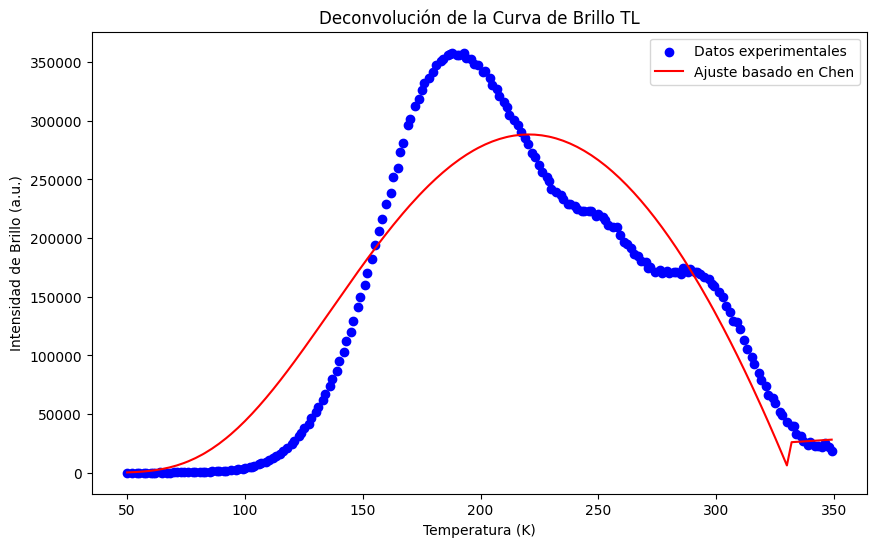

In [32]:
# Constante de Boltzmann en eV/K
k = 8.617333262145e-5

# Definición de la función para ajustar los picos de acuerdo al método de forma de pico de Chen (1997)
def chen_peak(T, A, E, Tm, b):
    """
    Función de ajuste basada en el método de Chen para el análisis de formas de picos TL.

    Parámetros:
    T : array de temperatura
    A : amplitud del pico
    E : energía de activación
    Tm : temperatura a la máxima intensidad del pico
    b : factor de forma

    Retorna:
    Intensidad del brillo termoluminiscente para cada T.
    """
    # Evitar valores negativos o muy pequeños para evitar cálculos indefinidos
    T = np.clip(T, 1e-6, None)  # Esto asegura que no haya valores cero o negativos
    term2 = 1 - (T / Tm)**b
    term2[term2 <= 0] = 1e-6  # Reemplazar valores negativos o cero por un número pequeño

    return A * np.exp(-E / (k * T)) * (term2)**(1 - b)

## Ajuste del modelo
initial_params = [350000, 0.836, 180, 2]  # Ajusta estos valores según lo necesario
bounds = ([0, 0, temperature.min(), 0], [np.inf, 2, temperature.max(), 2])
popt, pcov = curve_fit(chen_peak, temperature, xray, p0=initial_params, method='trf', bounds=bounds)
#popt, pcov = curve_fit(chen_peak, temperature, xray, p0=initial_params, bounds=bounds)

# Imprimir los parámetros ajustados
print("Parámetros ajustados:")
print("A (Amplitud) =", popt[0])
print("E (Energía de activación) =", popt[1])
print("Tm (Temperatura máxima) =", popt[2])
print("b (Factor de forma) =", popt[3])

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(temperature, xray, color='blue', label='Datos experimentales')
plt.plot(temperature, chen_peak(temperature, *popt), color='red', label='Ajuste basado en Chen')
plt.title('Deconvolución de la Curva de Brillo TL')
plt.xlabel('Temperatura (K)')
plt.ylabel('Intensidad de Brillo (a.u.)')
plt.legend()
plt.show()

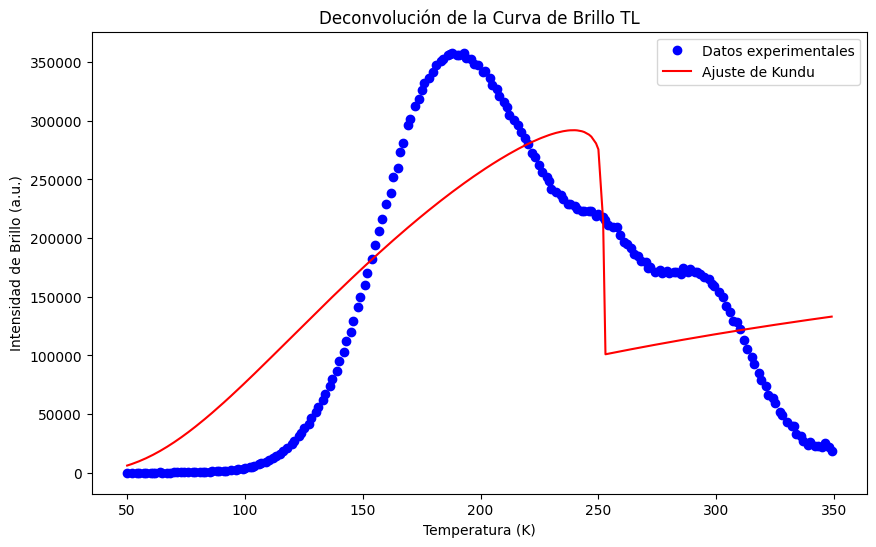

Parámetros ajustados: [1.00000000e+06 2.18727121e-02 2.52020923e+02 9.44003638e-01
 1.00000000e-02]


In [40]:
# Constante de Boltzmann en eV/K
k = 8.617333262145e-5

def kundu_peak(T, A, E, Tm, b, symmetry):
    T = np.maximum(T, 1e-10)  # Evita divisiones por cero
    x = T / Tm
    x = np.clip(x, 1e-10, 1-1e-10)  # Evita valores fuera de [0,1] para (1 - x**b)
    exp_component = np.exp(-E / (k * T))
    symmetry_term = ((x)**symmetry + (1/x)**symmetry) / 2
    term = (1 - x**b)
    term = np.maximum(term, 1e-10)  # Evita valores negativos para la potencia
    return A * exp_component * term**(1 - b) * symmetry_term

# Ajuste de la curva con los nuevos límites y parámetros iniciales adecuados
initial_params = [350000, 0.8, 180, 1.5, 3.0]  # Ajuste según tus datos y experiencia
bounds = ([1e-2, 1e-2, 50, 1e-2, 1e-2], [1e6, 2, 350, 3, 3])

popt, pcov = curve_fit(kundu_peak, temperature, xray, p0=initial_params, bounds=bounds)

# Gráfico para visualizar el ajuste
plt.figure(figsize=(10, 6))
plt.plot(temperature, xray, 'bo', label='Datos experimentales')
plt.plot(temperature, kundu_peak(temperature, *popt), 'r-', label='Ajuste de Kundu')
plt.xlabel('Temperatura (K)')
plt.ylabel('Intensidad de Brillo (a.u.)')
plt.title('Deconvolución de la Curva de Brillo TL')
plt.legend()
plt.show()

# Imprimir parámetros ajustados
print("Parámetros ajustados:", popt)

Parámetros ajustados: I0 = 278391.0919238885, E = 0.0092940377638875


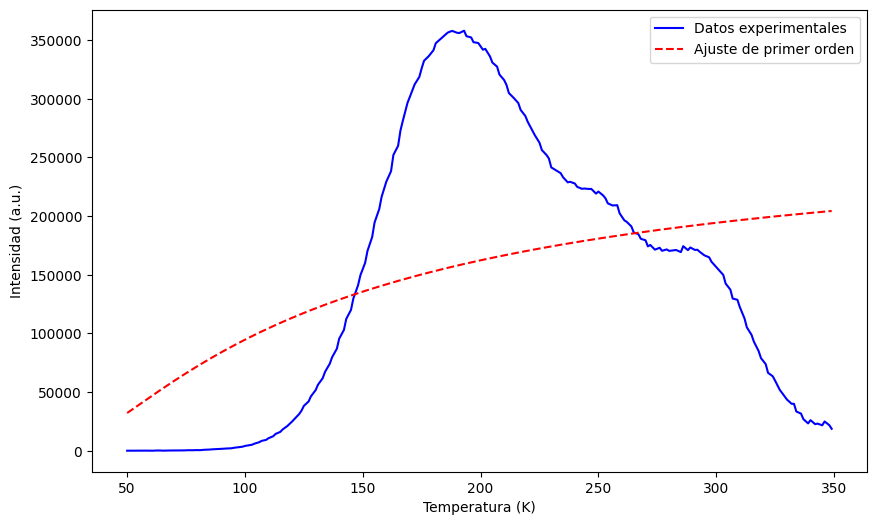

In [ ]:
# Vamos a simplificar el enfoque y ajustar una función de primer orden

# Definición de la función de primer orden sin parámetros adicionales complicados
def first_order_kinetics(T, I0, E, k=8.617e-5):
    return I0 * np.exp(-E / (k * T))

# Ajuste de la curva utilizando curve_fit con límites para evitar desbordamiento
popt, pcov = curve_fit(first_order_kinetics, temperature, xray, p0=[1e6, 0.5], bounds=(0, [1e10, 10]))

# Parámetros ajustados
I0_fit, E_fit = popt
print(f'Parámetros ajustados: I0 = {I0_fit}, E = {E_fit}')

# Curva ajustada
xray_fit = first_order_kinetics(temperature, I0_fit, E_fit)

# Gráfica de los resultados
plt.figure(figsize=(10, 6))
plt.plot(temperature, xray, 'b-', label='Datos experimentales')
plt.plot(temperature, xray_fit, 'r--', label='Ajuste de primer orden')
plt.xlabel('Temperatura (K)')
plt.ylabel('Intensidad (a.u.)')
plt.legend()
plt.show()

Parámetros ajustados:
Gaussiana 1: A = 2068.023111887288, T0 = 126.6096683597494, sigma = 5.358216748506038
Gaussiana 2: A = 275067.11541350454, T0 = 182.687975728681, sigma = 27.21016909329122
Gaussiana 3: A = 201798.20187509933, T0 = 246.92993779026577, sigma = 46.19247942690037
Gaussiana 4: A = 7002752.734113552, T0 = 301.9587066358663, sigma = 9.956622633017716
Gaussiana 5: A = -6951405.892550071, T0 = 301.96823658484374, sigma = 9.931405566250955
R² = 0.9996050338749524
FOM = 0.011452458486706396


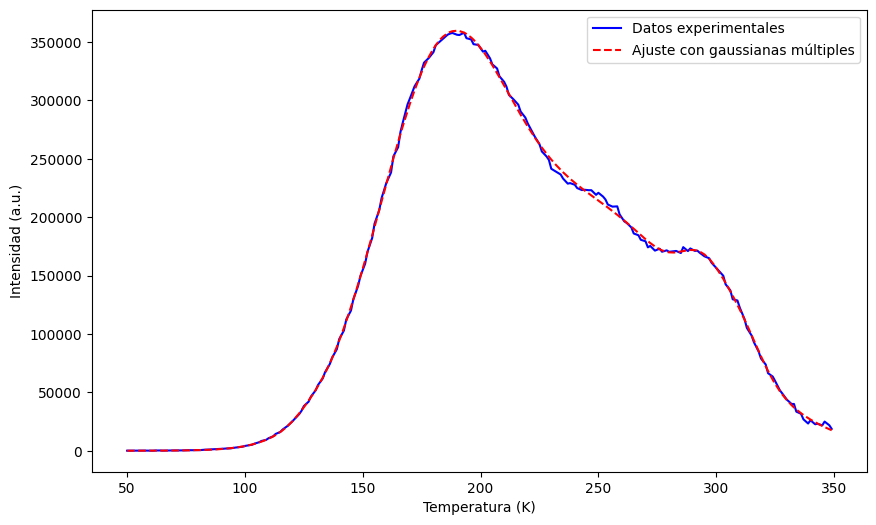

In [ ]:
# Vamos a utilizar un ajuste múltiple de funciones gaussianas

# Definición de una función gaussiana
def gaussian(T, A, T0, sigma):
    return A * np.exp(-(T - T0)**2 / (2 * sigma**2))

# Definición de una función con múltiples gaussianas
def multiple_gaussians(T, *params):
    n = len(params) // 3
    result = np.zeros_like(T, dtype=float)
    for i in range(n):
        A = params[3*i]
        T0 = params[3*i + 1]
        sigma = params[3*i + 2]
        result += gaussian(T, A, T0, sigma)
    return result

# Parámetros iniciales: amplitudes, posiciones y anchos de 5 gaussianas
initial_params = [1e5, 100, 10, 1e5, 150, 10, 1e5, 200, 10, 1e5, 250, 10, 1e5, 300, 10]

# Ajuste de la curva utilizando curve_fit
popt, pcov = curve_fit(multiple_gaussians, temperature, xray, p0=initial_params, maxfev=10000)

# Parámetros ajustados
print('Parámetros ajustados:')
for i in range(len(popt) // 3):
    print(f'Gaussiana {i+1}: A = {popt[3*i]}, T0 = {popt[3*i + 1]}, sigma = {popt[3*i + 2]}')

# Curva ajustada
xray_fit = multiple_gaussians(temperature, *popt)

# Calcular R² (coeficiente de determinación)
r2 = r2_score(xray, xray_fit)

# Calcular el FOM (Figure of Merit)
fom = np.sum(np.abs(xray - xray_fit)) / np.sum(xray)

print(f'R² = {r2}')
print(f'FOM = {fom}')

# Gráfica de los resultados
plt.figure(figsize=(10, 6))
plt.plot(temperature, xray, 'b-', label='Datos experimentales')
plt.plot(temperature, xray_fit, 'r--', label='Ajuste con gaussianas múltiples')

plt.xlabel('Temperatura (K)')
plt.ylabel('Intensidad (a.u.)')
plt.legend()
plt.show()

Parámetros ajustados en la escala normalizada:
Voigt 1: A = -0.24972563592811894, T0 = 0.33207122244706827, sigma = 1.1104472378456905e-05, gamma = 0.1590401300694771
Voigt 2: A = 0.5941851958596153, T0 = 0.4326086107452138, sigma = 0.07784930271505708, gamma = 0.10048913615533388
Voigt 3: A = 0.04848011935554786, T0 = 0.7508294549259101, sigma = 0.24615262272811844, gamma = -0.34272980062923813
Voigt 4: A = 2.277112777015588e-29, T0 = 0.8064248381779686, sigma = 0.2314250383219246, gamma = -2.546989492851296
Voigt 5: A = -3.55844777650048e-07, T0 = 0.9372695388779607, sigma = 0.14167236605417538, gamma = -0.6437197996529117
R² = 0.9998329332084513
FOM = 0.007673945661573709
Parámetros ajustados en la escala original:
Voigt 1: A = -89404.02519298994, T0 = 149.2892955116734, sigma = 0.0033202372411586145, gamma = 47.55299889077365
Voigt 2: A = 212723.647784505, T0 = 179.34997461281893, sigma = 23.276941511802065, gamma = 30.046251710444828
Voigt 3: A = 17356.319050360333, T0 = 274.49800

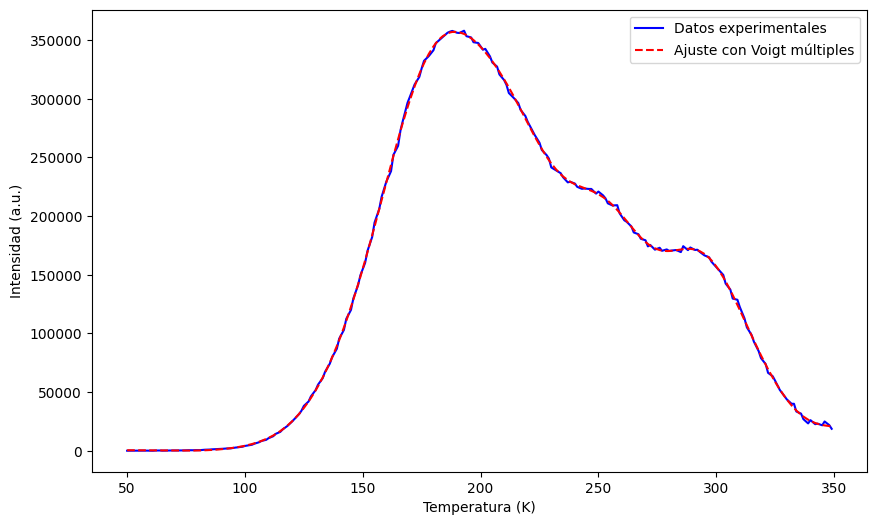

In [ ]:
# Deconvolución es el método de ajuste de picos Lorentzianos


# Normalizar los datos de temperatura e intensidad
temperature_norm = (temperature - np.min(temperature)) / (np.max(temperature) - np.min(temperature))
xray_norm = xray / np.max(xray)

# Definición de una función Voigt
def voigt(T, A, T0, sigma, gamma):
    return A * np.real(wofz(((T - T0) + 1j*gamma) / sigma / np.sqrt(2))) / sigma / np.sqrt(2*np.pi)

# Definición de una función con múltiples Voigt
def multiple_voigt(T, *params):
    n = len(params) // 4
    result = np.zeros_like(T, dtype=float)
    for i in range(n):
        A = params[4*i]
        T0 = params[4*i + 1]
        sigma = params[4*i + 2]
        gamma = params[4*i + 3]
        result += voigt(T, A, T0, sigma, gamma)
    return result

# Parámetros iniciales: amplitudes, posiciones, sigma y gamma de 5 Voigt
initial_params = [1, 0.2, 0.05, 0.05, 1, 0.4, 0.05, 0.05, 1, 0.6, 0.05, 0.05, 1, 0.8, 0.05, 0.05, 1, 1.0, 0.05, 0.05]

# Ajuste de la curva utilizando curve_fit
popt, pcov = curve_fit(multiple_voigt, temperature_norm, xray_norm, p0=initial_params, maxfev=50000)

# Parámetros ajustados en la escala normalizada
print('Parámetros ajustados en la escala normalizada:')
for i in range(len(popt) // 4):
    print(f'Voigt {i+1}: A = {popt[4*i]}, T0 = {popt[4*i + 1]}, sigma = {popt[4*i + 2]}, gamma = {popt[4*i + 3]}')

# Desnormalizar parámetros T0 a la escala original de temperatura
T0_original = popt[1::4] * (np.max(temperature) - np.min(temperature)) + np.min(temperature)

# Curva ajustada en la escala normalizada
xray_fit_norm = multiple_voigt(temperature_norm, *popt)
# Desnormalizar la curva ajustada a la escala original
xray_fit = xray_fit_norm * np.max(xray)

# Calcular R² (coeficiente de determinación)
r2 = r2_score(xray, xray_fit)

# Calcular el FOM (Figure of Merit)
fom = np.sum(np.abs(xray - xray_fit)) / np.sum(xray)

print(f'R² = {r2}')
print(f'FOM = {fom}')

# Parámetros ajustados en la escala original
print('Parámetros ajustados en la escala original:')
for i in range(len(popt) // 4):
    print(f'Voigt {i+1}: A = {popt[4*i] * np.max(xray)}, T0 = {T0_original[i]}, sigma = {popt[4*i + 2] * (np.max(temperature) - np.min(temperature))}, gamma = {popt[4*i + 3] * (np.max(temperature) - np.min(temperature))}')

# Gráfica de los resultados
plt.figure(figsize=(10, 6))
plt.plot(temperature, xray, 'b-', label='Datos experimentales')
plt.plot(temperature, xray_fit, 'r--', label='Ajuste con Voigt múltiples')

plt.xlabel('Temperatura (K)')
plt.ylabel('Intensidad (a.u.)')
plt.legend()
plt.show()